## Problem Statement

In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.
You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 players per group.
You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place).


Data fields</p>
* DBNOs - Number of enemy players knocked.
* assists - Number of enemy players this player damaged that were killed by teammates.
* boosts - Number of boost items used.
* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
* headshotKills - Number of enemy players killed with headshots.
* heals - Number of healing items used.
* Id - Player’s Id
* killPlace - Ranking in match of number of enemy players killed.
* killPoints - Kills-based external ranking of players. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* killStreaks - Max number of enemy players killed in a short amount of time.
* kills - Number of enemy players killed.
* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* matchDuration - Duration of match in seconds.
* matchId - ID to identify matches. There are no matches that are in both the training and testing set.
* matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* rankPoints - Elo-like ranking of players. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes the place of “None”.
* revives - Number of times this player revived teammates.
* rideDistance - Total distance traveled in vehicles measured in meters.
* roadKills - Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.
* teamKills - Number of times this player killed a teammate.
* vehicleDestroys - Number of vehicles destroyed.
* walkDistance - Total distance traveled on foot measured in meters.
* weaponsAcquired - Number of weapons picked up.
* winPoints - Win-based external ranking of players. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* numGroups - Number of groups we have data for in the match.
* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

##  Importing the Relevant Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  Data Inspection

In [3]:
train = pd.read_csv("/content/drive/MyDrive/Pub G competetion/train_V2.csv")
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [4]:
train.shape

(4446966, 29)

In [5]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,2.299759e+01,1.579506e+03,4.450467e+01,4.300759e+01,8.920105e+02,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,5.097262e+01,2.587399e+02,2.382811e+01,2.328949e+01,7.366478e+02,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,2.132000e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [6]:
#ratio of null values
train.isnull().sum()/train.shape[0] *100

Id                 0.000000
groupId            0.000000
matchId            0.000000
assists            0.000000
boosts             0.000000
damageDealt        0.000000
DBNOs              0.000000
headshotKills      0.000000
heals              0.000000
killPlace          0.000000
killPoints         0.000000
kills              0.000000
killStreaks        0.000000
longestKill        0.000000
matchDuration      0.000000
matchType          0.000000
maxPlace           0.000000
numGroups          0.000000
rankPoints         0.000000
revives            0.000000
rideDistance       0.000000
roadKills          0.000000
swimDistance       0.000000
teamKills          0.000000
vehicleDestroys    0.000000
walkDistance       0.000000
weaponsAcquired    0.000000
winPoints          0.000000
winPlacePerc       0.000022
dtype: float64

In [7]:
train=train.dropna(axis=0,how='any')

In [8]:
train.shape

(4446965, 29)

In [9]:
#categorical features
categorical = train.select_dtypes(include =[np.object])
print("Categorical Features in data Set:",categorical.shape[1])

#numerical features
numerical= train.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in data Set:",numerical.shape[1])

Categorical Features in data Set: 4
Numerical Features in data Set: 25


In [10]:
print(train.dtypes)

Id                  object
groupId             object
matchId             object
assists              int64
boosts               int64
damageDealt        float64
DBNOs                int64
headshotKills        int64
heals                int64
killPlace            int64
killPoints           int64
kills                int64
killStreaks          int64
longestKill        float64
matchDuration        int64
matchType           object
maxPlace             int64
numGroups            int64
rankPoints           int64
revives              int64
rideDistance       float64
roadKills            int64
swimDistance       float64
teamKills            int64
vehicleDestroys      int64
walkDistance       float64
weaponsAcquired      int64
winPoints            int64
winPlacePerc       float64
dtype: object


In [11]:
data_num=train.select_dtypes(include=['int','float'])
data_num.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


#### Select best 14 numerical features

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [13]:
X=data_num.iloc[:,:24] 
y=data_num.iloc[:,-1] 

In [14]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=14)
fit = bestfeatures.fit(X,y)

In [15]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [16]:
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']

In [17]:
featureScores

,Specs,Score
0,assists,257.630164
1,boosts,1275.441774
2,damageDealt,470.837614
3,DBNOs,279.771781
4,headshotKills,177.168541
5,heals,361.672391
6,killPlace,1701.167258
7,killPoints,26.227668
8,kills,442.610636
9,killStreaks,272.897484


In [18]:
print(featureScores.nlargest(15,'Score')) 

              Specs        Score
12         maxPlace  3427.788691
21     walkDistance  3420.115636
13        numGroups  3369.247349
6         killPlace  1701.167258
1            boosts  1275.441774
22  weaponsAcquired   833.686129
2       damageDealt   470.837614
8             kills   442.610636
10      longestKill   386.241574
5             heals   361.672391
3             DBNOs   279.771781
9       killStreaks   272.897484
0           assists   257.630164
16     rideDistance   221.008351
4     headshotKills   177.168541


## Univariate Analysis

In [19]:
# Outliers detector
def detect_outliers(data):
    outliers=[]
    threshold=3
    mean = np.mean(data)
    std =np.std(data)
    
    
    for i in data:
        z_score= (i - mean)/std 
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

##### maxPlace

{'boxes': [<matplotlib.lines.Line2D at 0x7f3aa72d81d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3aa72e6250>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3aa72ca810>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f3aa72e6d10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3aa72d8790>,
  <matplotlib.lines.Line2D at 0x7f3aa72d8cd0>]}

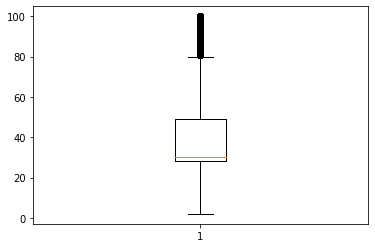

In [20]:
plt.boxplot(train['maxPlace'])

* Maxplace above 80 is very rare.

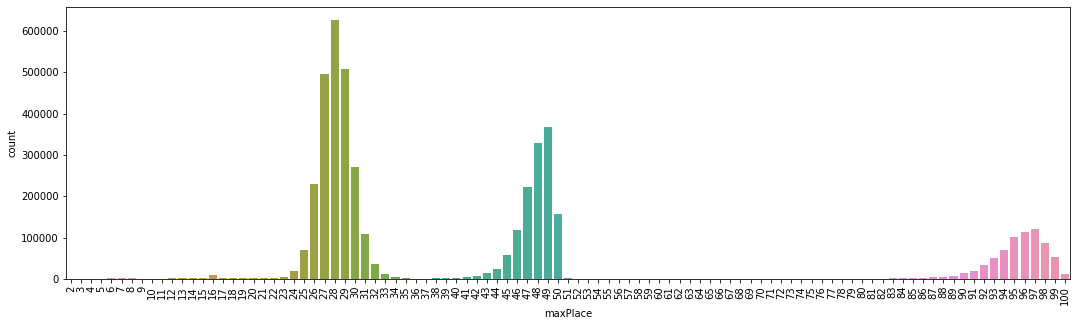

In [21]:
plt.figure(figsize=(18,5))
sns.countplot(x='maxPlace',data=train)
plt.xticks(rotation=90)
plt.show()

* More 0.6 Million people get 29 maxplace.
* Around Half Million people able to get 27 and 29 maxPlace.


In [22]:
#outlier_maxPlace=detect_outliers(train['maxPlace'])
#print("outliers of Salary: ",outlier_maxPlace)
#print("maxPlace above 80: ",len(outlier_maxPlace))

#### killPlace

{'boxes': [<matplotlib.lines.Line2D at 0x7f3aa6ac7f50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3aa6accf50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3aa6ad3f90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f3aa6ad3a50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3aa6acc4d0>,
  <matplotlib.lines.Line2D at 0x7f3aa6acca10>]}

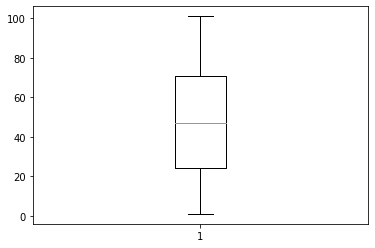

In [23]:
plt.boxplot(train['killPlace'])

* Right skewed distribution
* Outliers or rare points are present above 5000.

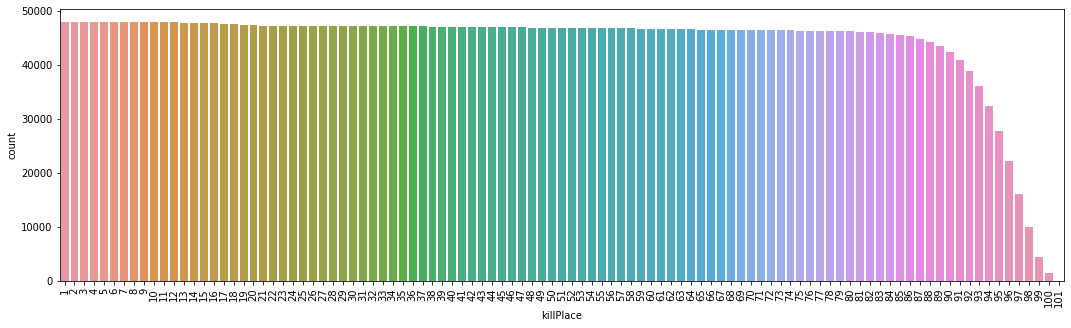

In [24]:
plt.figure(figsize=(18,5))
sns.countplot(x='killPlace',data=train)
plt.xticks(rotation=90)
plt.show()

* Around Half million people get 1st killPlace.
* Very few people get killPlace above 99.

#### boosts

{'boxes': [<matplotlib.lines.Line2D at 0x7f3aa67e9a50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3aa676ba90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3aa6773ad0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f3aa6773590>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3aa67e9fd0>,
  <matplotlib.lines.Line2D at 0x7f3aa676b550>]}

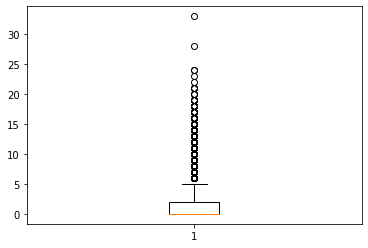

In [25]:
plt.boxplot(train['boosts'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


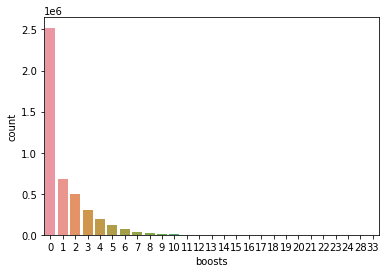

In [26]:
sns.countplot(train['boosts'])

* 2 million users not able to use boost items.
* More than half million people able to use 1 boost item
* Around half million people able to use 2 boost item

#### weaponsAcquired

{'boxes': [<matplotlib.lines.Line2D at 0x7f3aa6646390>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3aa664b390>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3aa66533d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f3aa664be50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3aa66468d0>,
  <matplotlib.lines.Line2D at 0x7f3aa6646e10>]}

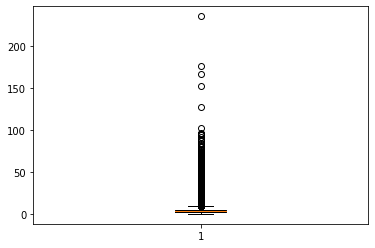

In [27]:
plt.boxplot(train['weaponsAcquired'])

* Very few people get weapons more than one.

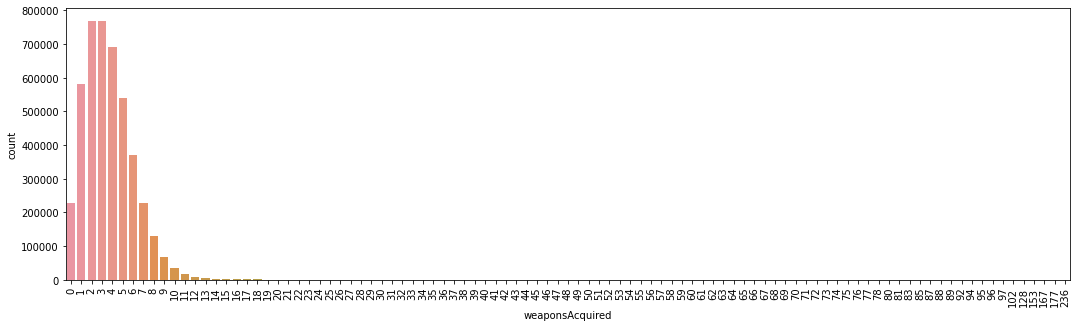

In [28]:
plt.figure(figsize=(18,5))
sns.countplot(x='weaponsAcquired',data=train)
plt.xticks(rotation=90)
plt.show()

* More tha 0.7 million people able to pick 4 and 5 number of weapons.
*0.2 Million people get zero weapon 

#### damageDealt

{'boxes': [<matplotlib.lines.Line2D at 0x7f3aa6539c90>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3aa652dd10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3aa6487b10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f3aa64874d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3aa6539290>,
  <matplotlib.lines.Line2D at 0x7f3aa652d650>]}

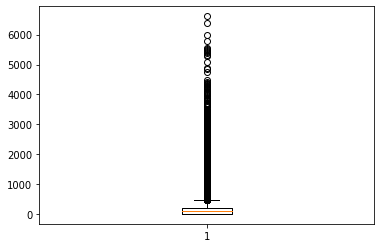

In [29]:

plt.boxplot(train['damageDealt'])

In [30]:
outlier_damageDealt=detect_outliers(train['damageDealt'])
print("outliers of damageDealt: ",outlier_damageDealt)
print("damageDealt above 700: ",len(outlier_damageDealt))

outliers of damageDealt:  [1011.0, 778.0, 902.5, 1101.0, 1120.0, 704.1, 1563.0, 853.1, 966.8, 817.0, 704.9, 800.7, 1036.0, 695.3, 784.5, 743.1, 938.2, 723.9, 714.4, 689.9, 739.8, 1750.0, 751.9, 655.2, 722.8, 919.5, 792.2, 682.3, 711.8, 813.6, 1028.0, 717.7, 886.5, 722.4, 651.8, 1228.0, 1018.0, 744.8, 658.7, 646.4, 1039.0, 845.7, 1008.0, 749.0, 873.1, 680.7, 805.3, 1098.0, 738.9, 741.6, 708.3, 820.4, 682.8, 2325.0, 688.5, 819.7, 875.5, 1240.0, 1013.0, 970.5, 907.2, 757.1, 760.3, 800.5, 719.1, 781.6, 970.3, 780.5, 672.3, 979.4, 1010.0, 757.8, 1357.0, 651.4, 671.3, 725.2, 751.0, 1145.0, 929.8, 703.7, 660.2, 1093.0, 748.7, 864.0, 722.0, 699.8, 940.1, 751.7, 900.9, 787.5, 894.2, 745.5, 912.1, 896.2, 771.9, 788.1, 686.9, 834.4, 822.6, 1502.0, 931.0, 731.9, 710.6, 899.7, 862.9, 689.0, 1313.0, 745.7, 1153.0, 663.0, 2033.0, 729.2, 683.2, 684.1, 753.6, 1024.0, 857.5, 777.8, 781.4, 804.4, 775.1, 861.9, 924.3, 956.8, 823.5, 690.4, 648.4, 659.9, 766.4, 811.3, 668.7, 658.6, 940.8, 765.6, 659.5, 687.

#### kills

{'boxes': [<matplotlib.lines.Line2D at 0x7f3aa655e950>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3aa6621ed0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3aa66654d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f3aa6665990>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3aa655eb90>,
  <matplotlib.lines.Line2D at 0x7f3aa6621ad0>]}

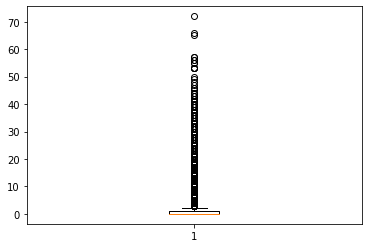

In [31]:
plt.boxplot(train['kills'])

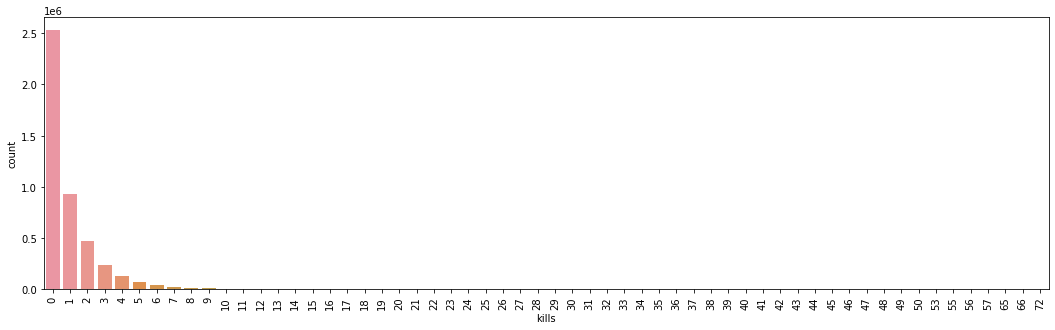

In [32]:
plt.figure(figsize=(18,5))
sns.countplot(x='kills',data=train)
plt.xticks(rotation=90)
plt.show()

* 2.5 Million users Didnt able to kill anyone.
* 1 million Users able to kill 1 enemy.
* 0.5 Million users able to kill 2 enemies.

#### heals

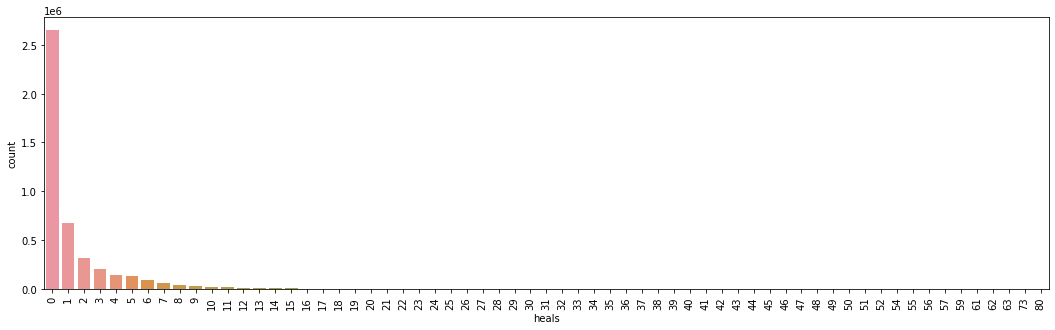

In [33]:
plt.figure(figsize=(18,5))
sns.countplot(x='heals',data=train)
plt.xticks(rotation=90)
plt.show()


* More 2.5 Million users are not able to use heals items.
* Around 0.7 Million users able to use heals items.
* 0.25 Million people able use  3 heals.

#### DBNOs

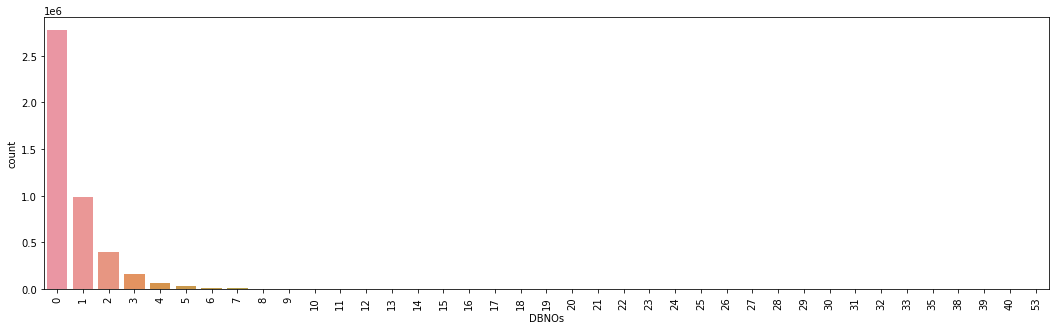

In [34]:
plt.figure(figsize=(18,5))
sns.countplot(x='DBNOs',data=train)
plt.xticks(rotation=90)
plt.show()


* Around 3 Million users not Able to knocked any enemy.
* 1 million users knocked 1 enemy.


#### killStreaks

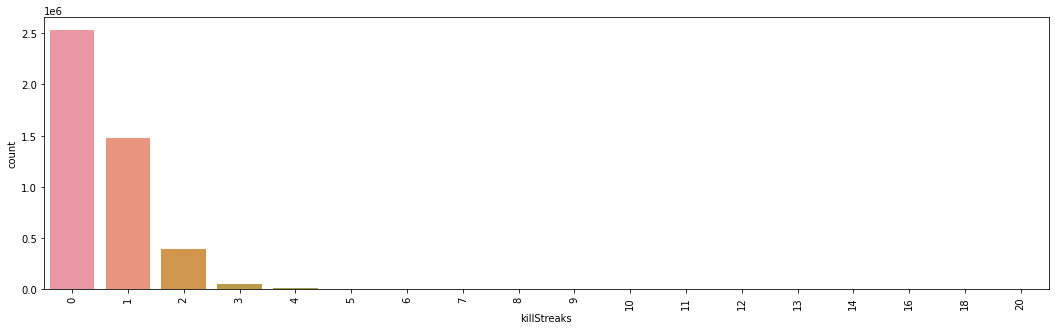

In [35]:
plt.figure(figsize=(18,5))
sns.countplot(x='killStreaks',data=train)
plt.xticks(rotation=90)
plt.show()


* 2.5 Million players not able to kill any enemy in short period of time.
* 1.5 Million players able to kill 1 enemy in short period of time.

##### matchType

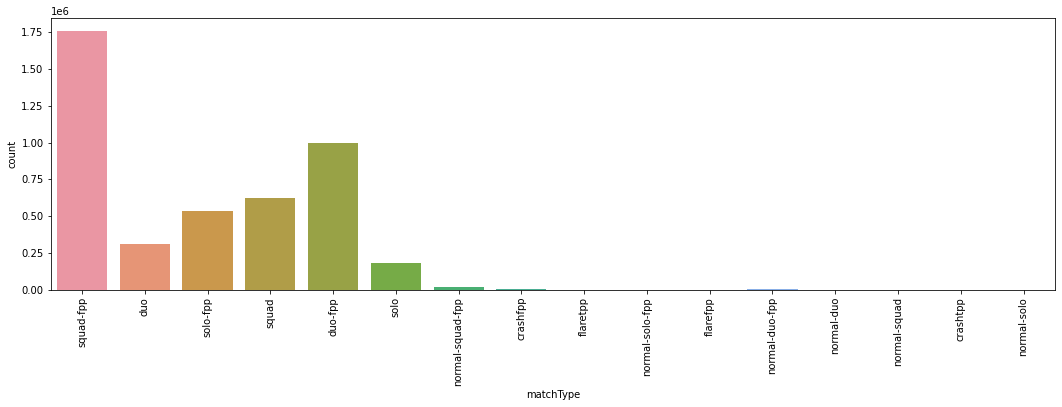

In [36]:
plt.figure(figsize=(18,5))
sns.countplot(x='matchType',data=train)
plt.xticks(rotation=90)
plt.show()

* 1.75 Million people used to play squad-fpp match type.
* 0.25 Million People used to play duo match type.
* 0.50 Million People used to play solo-fpp match type.
* 1  Million People used to play duo-fpp match type.
* 0.60  Million People used to play squad match type.
*Around 0.1  Million People used to play solo match type.
* Other match types are very rarely played.

##### winPlacePerc

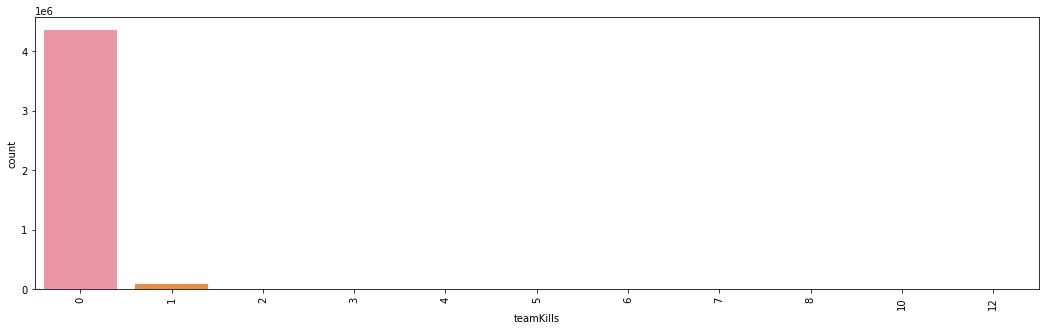

In [37]:
plt.figure(figsize=(18,5))
sns.countplot(x='teamKills',data=train)
plt.xticks(rotation=90)
plt.show()